# Quarterly QA on Philips Scanners

This is performed on the Philips "1.5L bottle" phantom in the most used head coil.

The bandwidth used should be approximately scaled with the field strength so 130Hz at 1.5T and 260Hz at 3.0T.

The quarterly QA scans consist of the following scans:
 - SE, 2 acquisitions, with/without PSN, multiple elements, RMS coil combine -> SNR, Unif, XY gradient scale
 - SE, 2 acquisitions, without PSN, multiple elements, RMS coil combine, TX switched off by setting reference voltages to zero
 - EPI, 60+ acquisitions, ghosting and long term stability, eddy currents and shim (distortion)

The acquistions should have the following labels in the protocol to make them easier to identify:
 - `QQA_SE_SIGNAL`
 - `QQA_SE_NOISE`
 - `QQA_EPI_STABILITY`
 
Although we may well have multiple series for each label we should be able to deduce which is which based on the image type, coil names and coil element masks.

In [1]:
from __future__ import division, print_function

# Patient details file yaml/json
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mriqa.phantoms import PHILIPS2LBOTTLE

from mriqa.dcmio import fetch_series, coil_elements, larmor_frequency
from mriqa.tools import show_montage

from mriqa.reports import (
    ghosting_report, uniformity_report, noise_correlation_report,
    circularity_report, snr_report_multi, snr_report
)

### Details of series to analyse.

In [2]:
with open('study.yml') as f:
    study_info = yaml.safe_load(f)
patid = study_info['PatID']
studyid = study_info['StudyID']
series = study_info['Series']

phantom = PHILIPS2LBOTTLE

display(
    pd.DataFrame(
        {'Details':[patid, studyid] + list(series.values())}, 
        index=['Patient', 'Study'] + list(series.keys())
    )
)

Details
Patient          QQA20190424NBTMR22
Study                     601307077
Signal                        [403]
Signal_Combined               [404]
Noise                          None
Noise_Combined                 None
Geometry                      [405]

### Individual coil element images

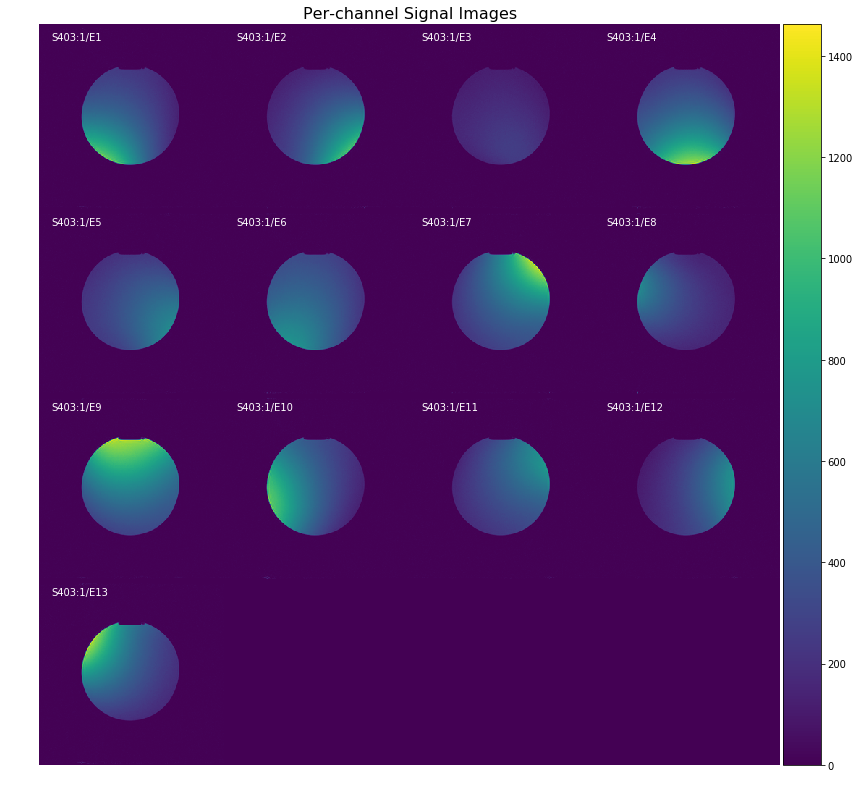

In [3]:
# Assume just one element
dobjs = fetch_series(patid, studyid, sernos=series['Signal'], imagesonly=True)
show_montage(dobjs, None, op='mean', cmap='viridis', title='Per-channel Signal Images');

## Signal to Noise Ratio

Signal to noise ratio using uncombined signal images, which we combine here as sum of squares.

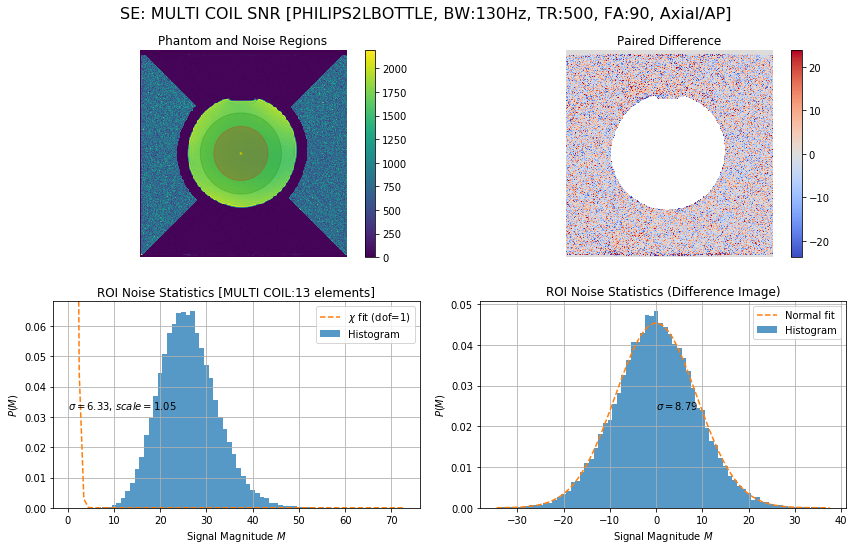

MULTI COIL
0.50  263.099238
0.75  267.591287

In [4]:
# SNR (uncombined channels)
dobjs = fetch_series(patid, studyid, sernos=series['Signal'], imagesonly=True)
snr_report_multi(dobjs, None, phantom=phantom)

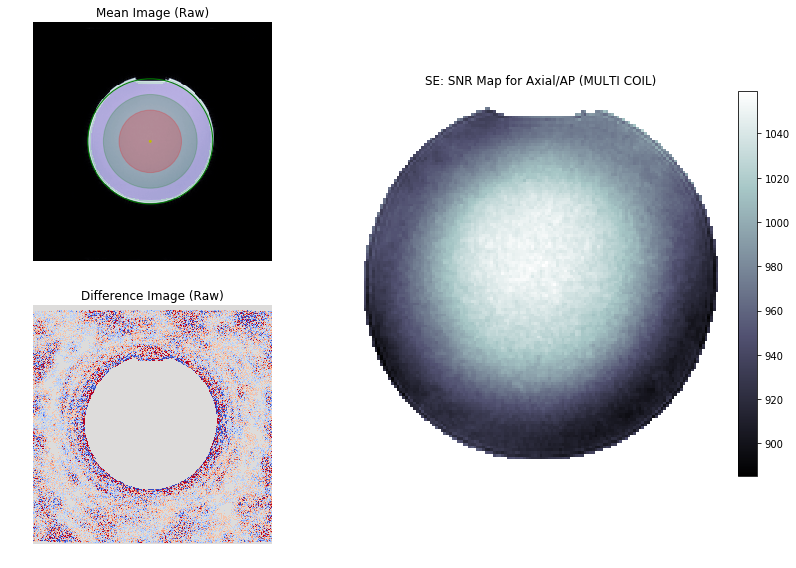

MULTI COIL
RegionSize             
0.50        1031.727402
0.75        1002.541475

In [5]:
# SNR (combined channels)
dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'], imagesonly=True)
snr_report(dobjs, None, phantom=phantom)

-------

## Geometry
For geometrical measures we want to look at the average of the coil-combined images with intensity correction applied. This will give us the highest SNR and the most uniform image, which should make the segmentation more robust wthout affecting the image geometry.

### Phantom Circularity (Scale and Distortion)

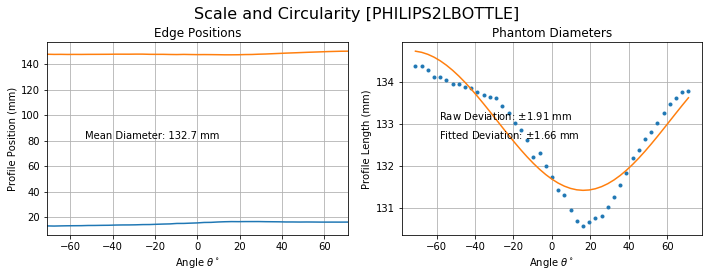

PHILIPS2LBOTTLE
Nominal               133.000000
Diameter              132.728750
Deviation               1.910523
FittedDeviation         1.657073

In [6]:
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Geometry'], imagesonly=True),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber))
)
circularity_report(dobjs[0], phantom=phantom, excluded_sector=38).T

-------------

### Ghosting
We can use the same routines for ghosting as for the small GE sphere. As the phantom is cylindrical, of course, only the axial plane will be considered.

Note that the actual values obtained for the ghosting ratio will vary somewhat according to exactly where the ghosting regions of interest are defined. In particular, any ringing-like behaviour will only be detected with a ROI close to the phantom. Nyquist ghosting on the other hand is best detected with an ROI that comprises the phantom shifted by N/2 in the *phase encoding* direction.

As the test compares background signal in the phase encoding and the readout direction we are only sensitive to these separately (generally in the phase encoding direction). Anything that is manifest on both axes will cancel out in the subtraction. Possibly a better point of comparison would be the image corners.

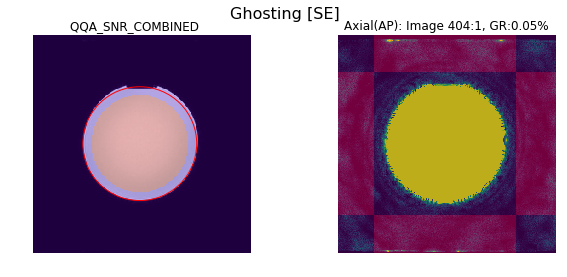

Series                    404
Protocol     QQA_SNR_COMBINED
Orientation             Axial
Sequence                   SE
GhostRatio          0.0481687

In [7]:
# BOTTLE: Ghosting
dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'], imagesonly=True)

results = ghosting_report([dobjs[0]], phantom=phantom)
results[['Protocol', 'Orientation', 'Sequence', 'GhostRatio']].T

----

### Uniformity
These are the same routines for uniformity as for the oil sphere used at acceptance but the phantom is cylindrical so only the axial plane is considered. Note that, at 3T there will be a significant contribution from the $B_1^+$ non-uniformity as well as from the receive coil sensitivities. Only some of this may be compensated for by the prescan normalize option; the scans used to calibrate this may have different sensitivity to flip angle variations. On the other hand this is quite a small phantom so the $B_1^+$ effects may not be very pronounced over such a limited volume.

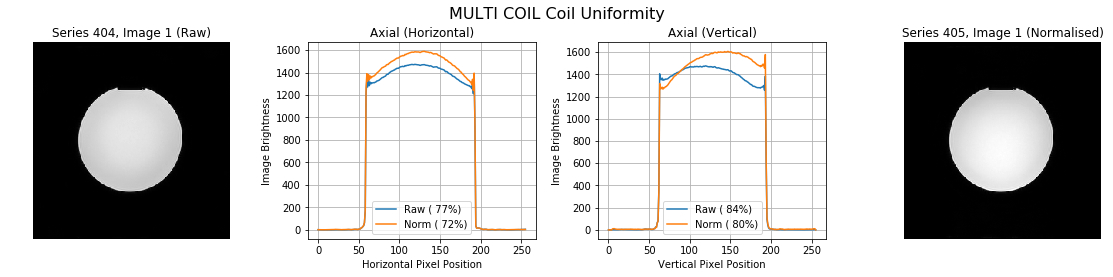

Orientation            Axial
XUniformityRaw     77.037037
YUniformityRaw     84.090909
NEMAUniformityRaw  96.400112

In [8]:
raw_dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'], imagesonly=True)
psn_dobjs = fetch_series(patid, studyid, sernos=series['Geometry'], imagesonly=True)

df = uniformity_report(raw_dobjs=raw_dobjs[:1], psn_dobjs=psn_dobjs[:1], phantom=phantom)
df[['XUniformityRaw', 'YUniformityRaw', 'NEMAUniformityRaw']].T

In [9]:
df[['XUniformityNorm', 'YUniformityNorm', 'NEMAUniformityNorm']].T

Orientation             Axial
XUniformityNorm     71.851852
YUniformityNorm     80.303030
NEMAUniformityNorm  95.416403

### Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM headers.

In [10]:
dobj = raw_dobjs[0]
pd.DataFrame({
    'ImagingFrequency': [larmor_frequency],
    'TransmitterCalibration': [float(csa_tags['TransmitterCalibration'])],
    'TalesReferencePower': [float(csa_tags['TalesReferencePower'])],
    'GradientSensitivityX': [
        float(phoenix_tags['sGRADSPEC.flSensitivityX']) * 1e6,
    ],
    'GradientSensitivityY': [
        float(phoenix_tags['sGRADSPEC.flSensitivityY']) * 1e6,
    ],
    'GradientSensitivityZ': [
        float(phoenix_tags['sGRADSPEC.flSensitivityZ']) * 1e6
    ]
}, index=['Value']).T

NameError: name 'csa_tags' is not defined